In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scienceplots

import ams
import andes

In [2]:
%matplotlib inline

In [3]:
case_path = "./../cases"
res_path = "./../results"

In [4]:
sp = ams.load(case_path + '/IL200_opf2.xlsx',
              setup=True, no_output=True,
              default_config=True)

# NOTE: 1) the maximum number of dispatch should follow: "D * Dispatch_interval <= 3600"
#       2) the maximum number of AGC should follow: "Dispatch_interval % AGC_interval == 0"

Dispatch_interval = 900  # seconds
AGC_interval = 15  # seconds

pq_idx = sp.PQ.idx.v
p0 = sp.PQ.p0.v.copy()
q0 = sp.PQ.q0.v.copy()

stg = sp.StaticGen.get_all_idxes()

stg_idxes = sp.StaticGen.find_idx(keys='gentype',
                                  values=['W2', 'PV', 'ES'],
                                  allow_all=True)

stg_w2t, stg_pv, stg_ess = stg_idxes

p0_w2t = sp.StaticGen.get(src='p0', attr='v', idx=stg_w2t)
p0_pv = sp.StaticGen.get(src='p0', attr='v', idx=stg_pv)

In [5]:
opf_res = pd.read_json(f"{res_path}/opf.json")

In [6]:
wind = [sp.config.mva * p0_w2t.sum() * opf_res[col]['wind'] for col in opf_res.columns]
solar = [sp.config.mva * p0_pv.sum() * opf_res[col]['solar'] for col in opf_res.columns]
gen = [sp.config.mva * np.sum(opf_res[col]['pg']) for col in opf_res.columns]
load = [sp.config.mva *np.sum(opf_res[col]['pd']) for col in opf_res.columns]

In [7]:
plt.style.use(["default", "ieee"])

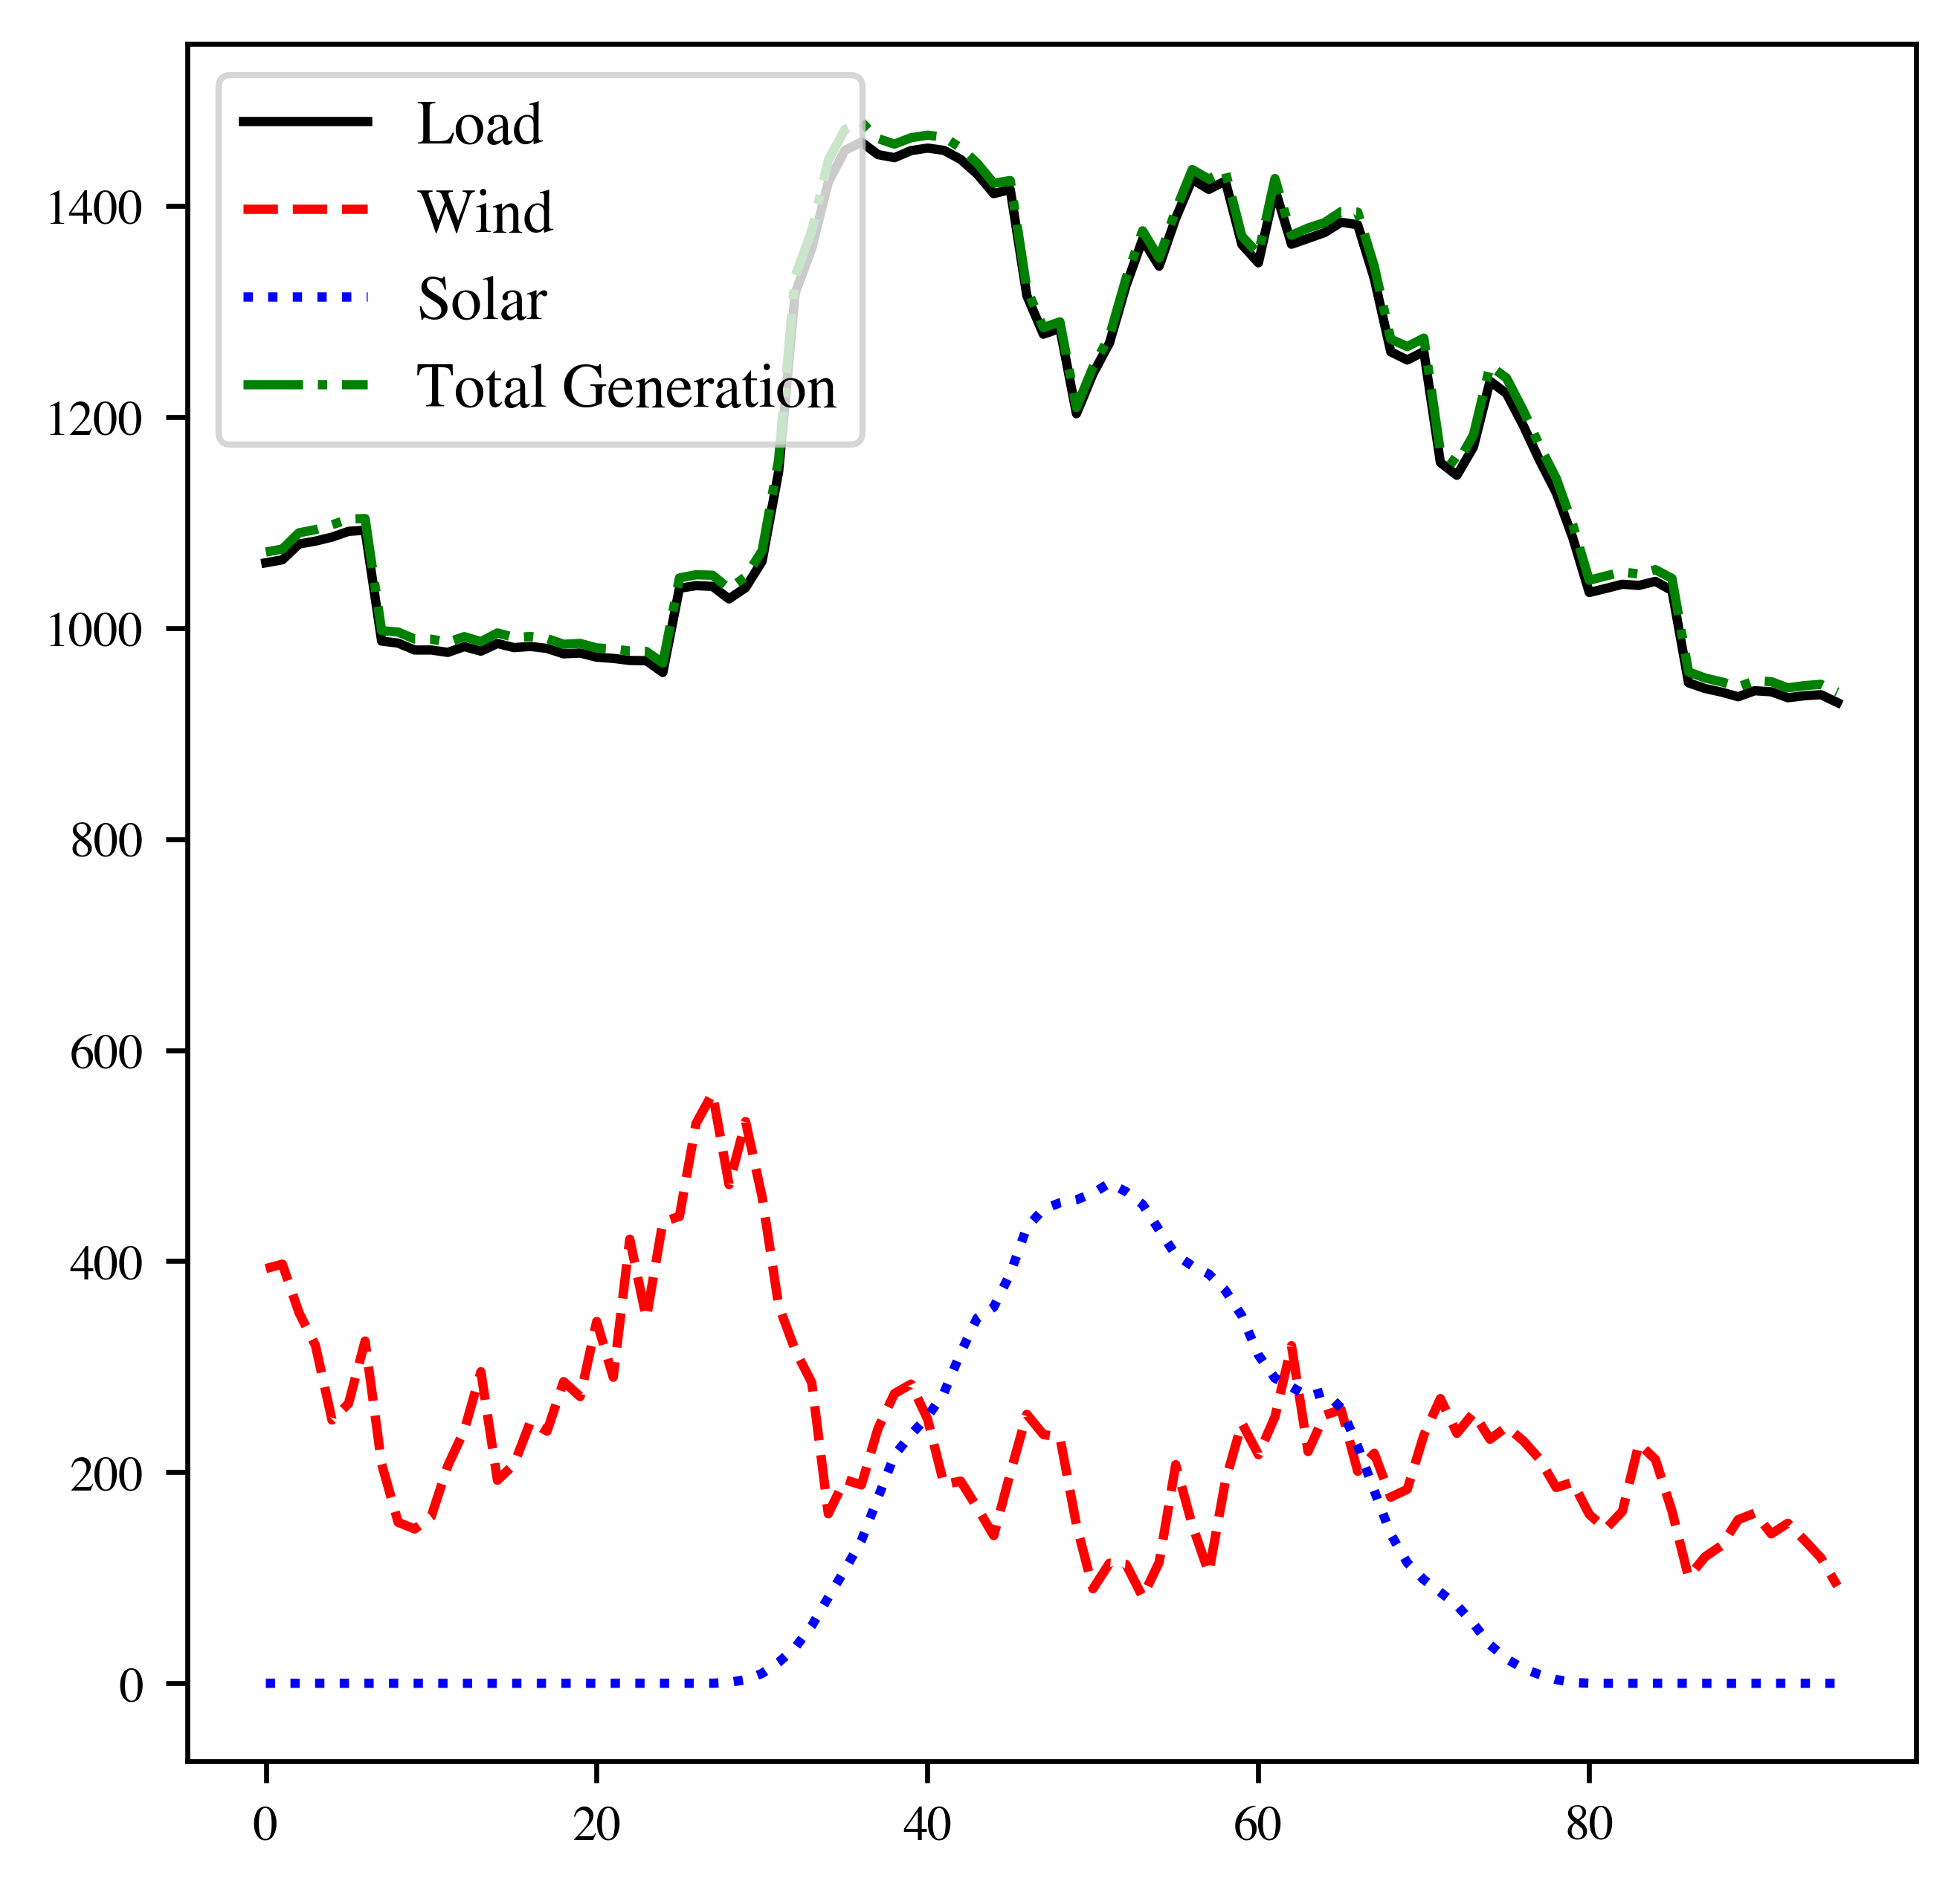

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

_ = ax.plot(range(opf_res.shape[1]), load, label='Load')
_ = ax.plot(range(opf_res.shape[1]), wind, label='Wind')
_ = ax.plot(range(opf_res.shape[1]), solar, label='Solar')
_ = ax.plot(range(opf_res.shape[1]), gen, label='Total Generation')
_ = ax.legend(loc='upper left', fontsize=10)

In [9]:
res_csv = f"{res_path}/tds_h22_d1.csv"
res = pd.read_csv(res_csv)
res = res.iloc[1:]

Here, we load an ANDES system for easier plotting.

In [10]:
case_path = "./../cases"
res_path = "./../results"
addfile = case_path + '/IL200_dyn_db2.xlsx'

# --- file loading ---
curve = pd.read_csv(case_path + '/CurveInterp.csv')

sp = ams.load(case_path + '/IL200_opf2.xlsx',
              setup=True, no_output=True,
              default_config=True)

sa = andes.load(addfile,
                setup=False, no_output=True,
                default_config=True)

sa.add('Output', dict(model='GENROU', varname='omega', dev='GENROU_47'))
sa.add('Output', dict(model='GENROU', varname='Pe'))
sa.add('Output', dict(model='PVD2', varname='v'))
sa.add('Output', dict(model='PVD2', varname='Ipcmd_y'))
sa.add('Output', dict(model='PVD2', varname='Pext'))
sa.add('Output', dict(model='ESD2', varname='v'))
sa.add('Output', dict(model='ESD2', varname='Ipcmd_y'))
sa.add('Output', dict(model='ESD2', varname='Pext'))
sa.setup()

sa.PFlow.run()

sa.TDS.config.no_tqdm = True
sa.TDS.run(from_csv=res_csv)

Generating code for 1 models on 12 processes.


GENROU (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENROU_7  | 0.865  | 1    
 GENROU_38 | 0.977  | 1    


/Users/jinningwang/work/andes/andes/core/model/model.py:790: ComplexWarning: Casting complex values to real discards the imaginary part
  instance.v = np.array(func(*self.s_args[name]),
/Users/jinningwang/work/andes/andes/core/model/model.py:829: ComplexWarning: Casting complex values to real discards the imaginary part
  instance.v[:] = func(*self.s_args[name])


True

(<Figure size 3000x3000 with 1 Axes>, <Axes: >)

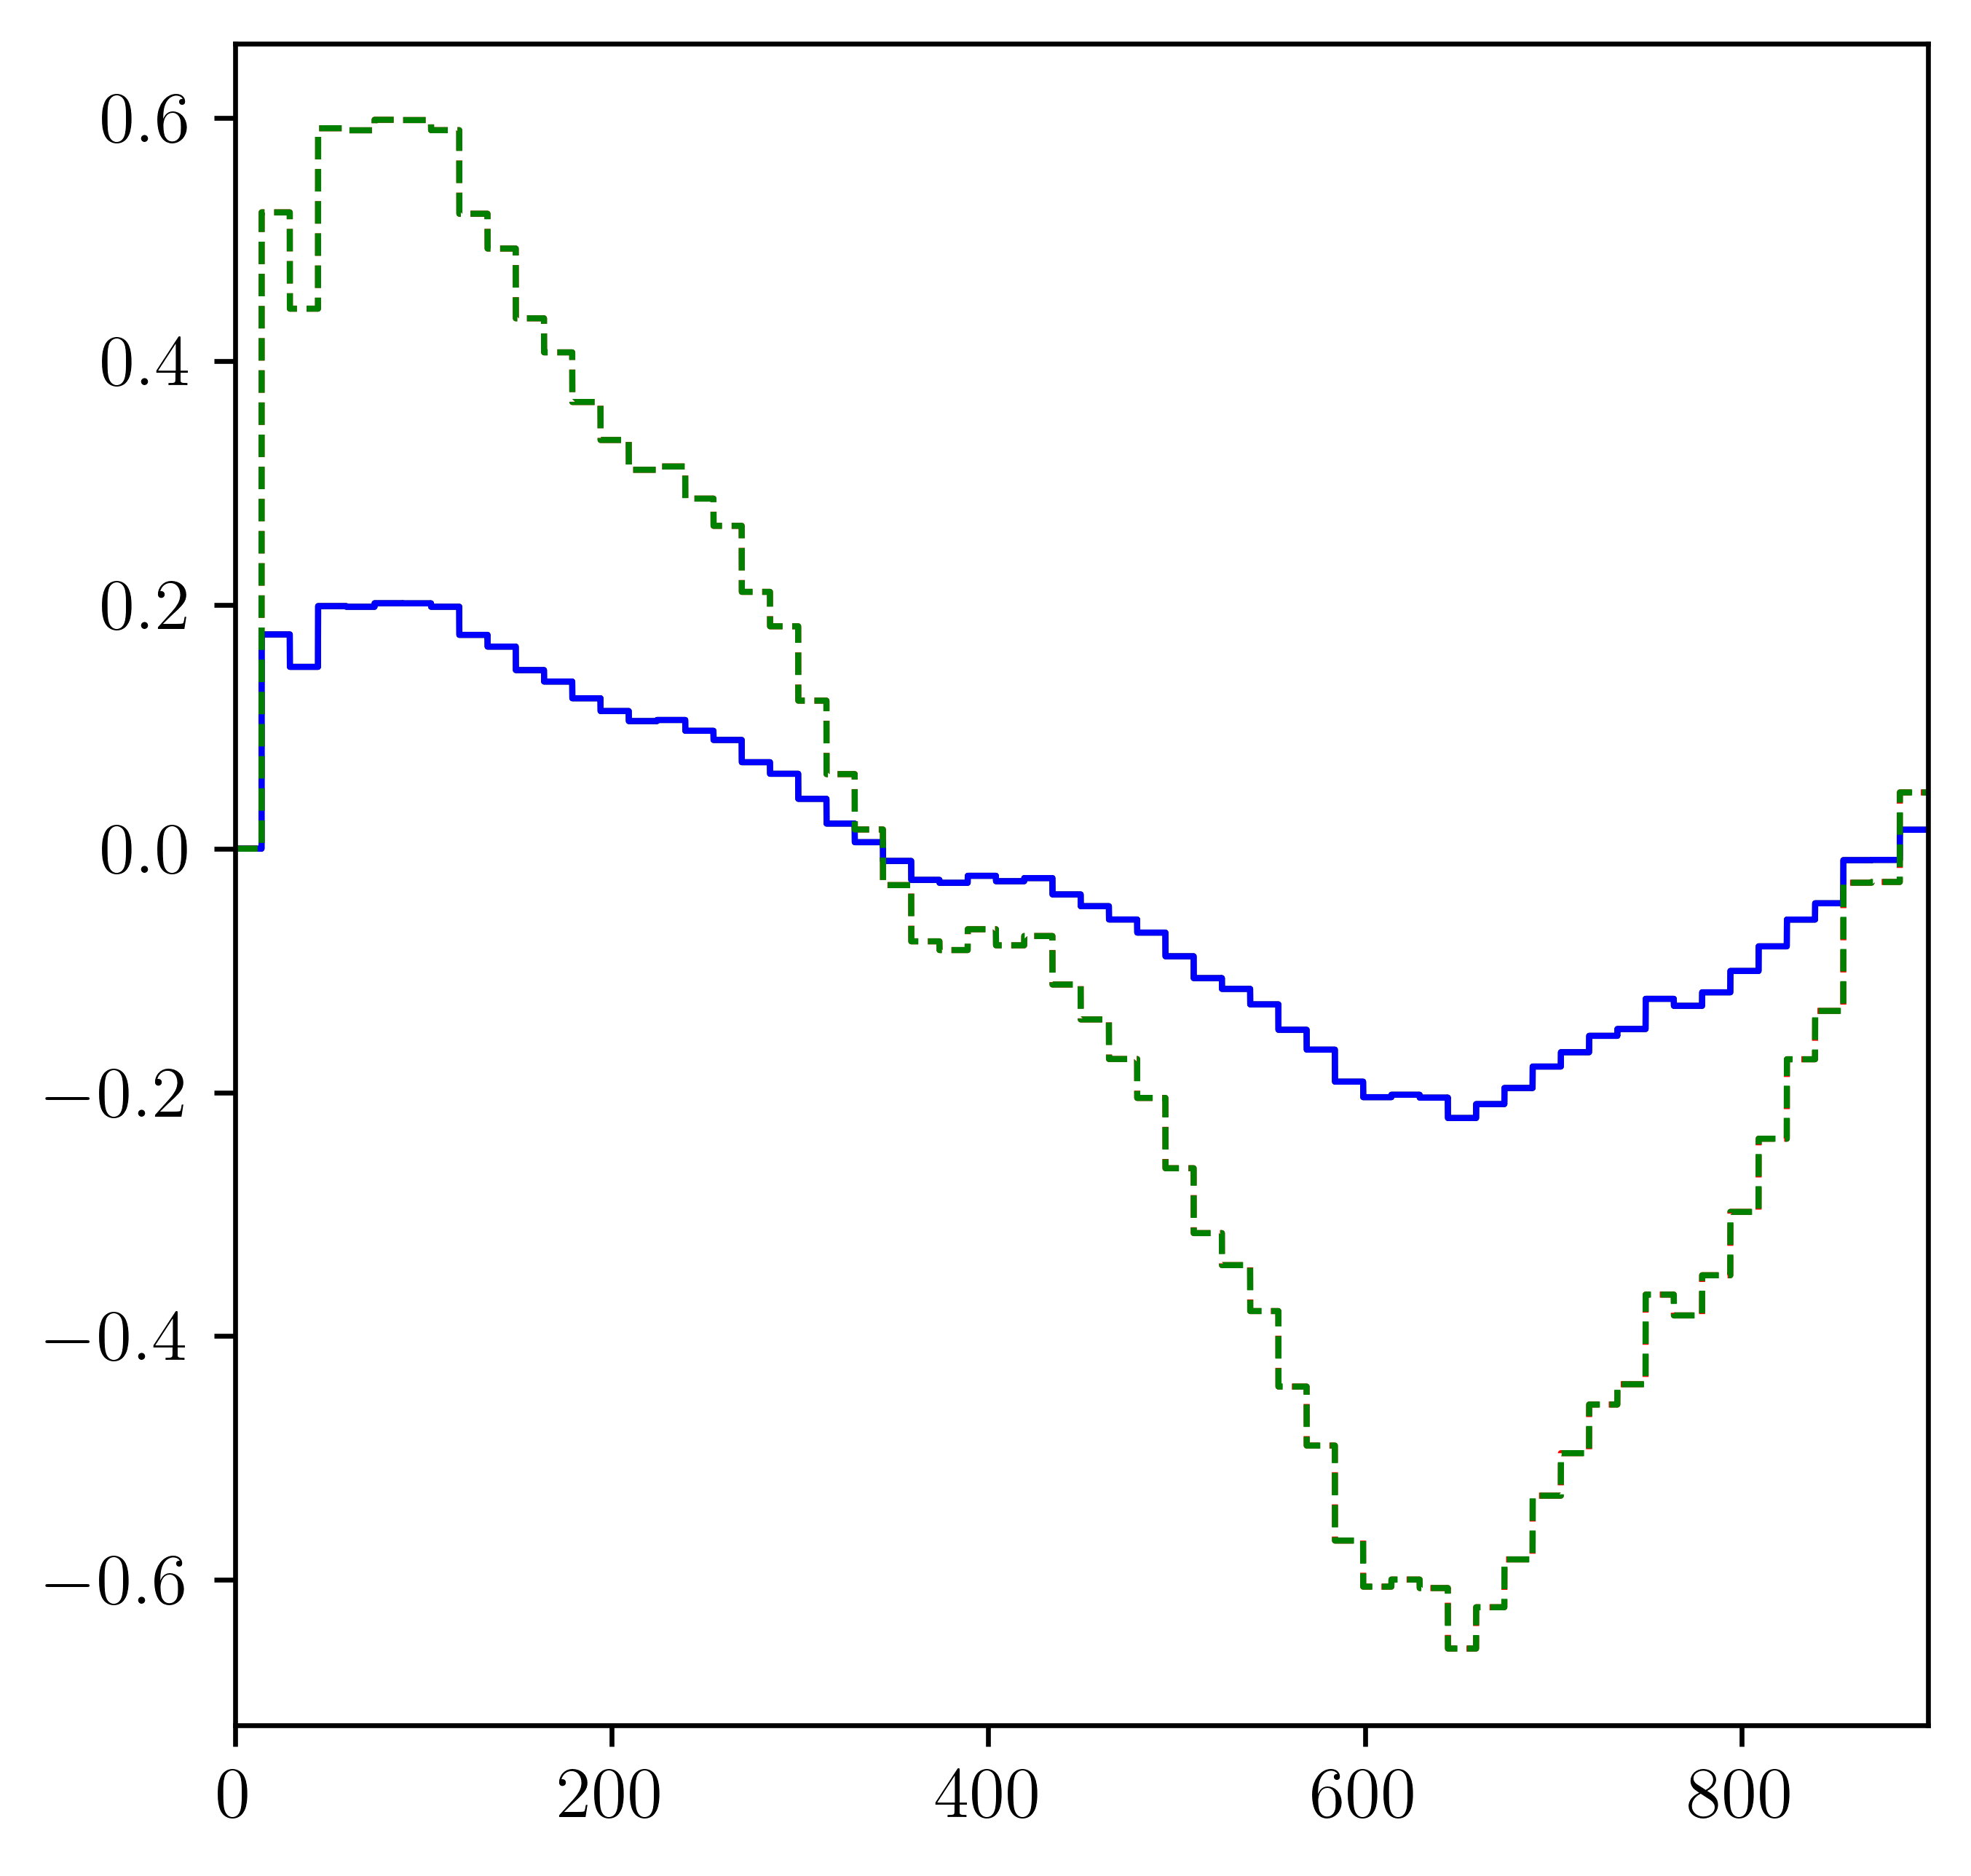

In [11]:
esd2_pe = sa.config.mva * \
    sa.dae.ts.get_data(sa.ESD2.Ipcmd_y) * sa.dae.ts.get_data(sa.ESD2.v)
esd2_paux = sa.config.mva * sa.dae.ts.get_data(sa.ESD2.Pext)

# Output power
fig0, ax0 = sa.TDS.plt.plot_data(sa.dae.ts.t,
                                 esd2_pe,
                                 figsize=(5, 5),
                                 style=["default", "ieee"],
                                 show=False,)
# AGC power signal
sa.TDS.plt.plot_data(sa.dae.ts.t,
                     esd2_paux,
                     fig=fig0, ax=ax0,
                     show=False,)

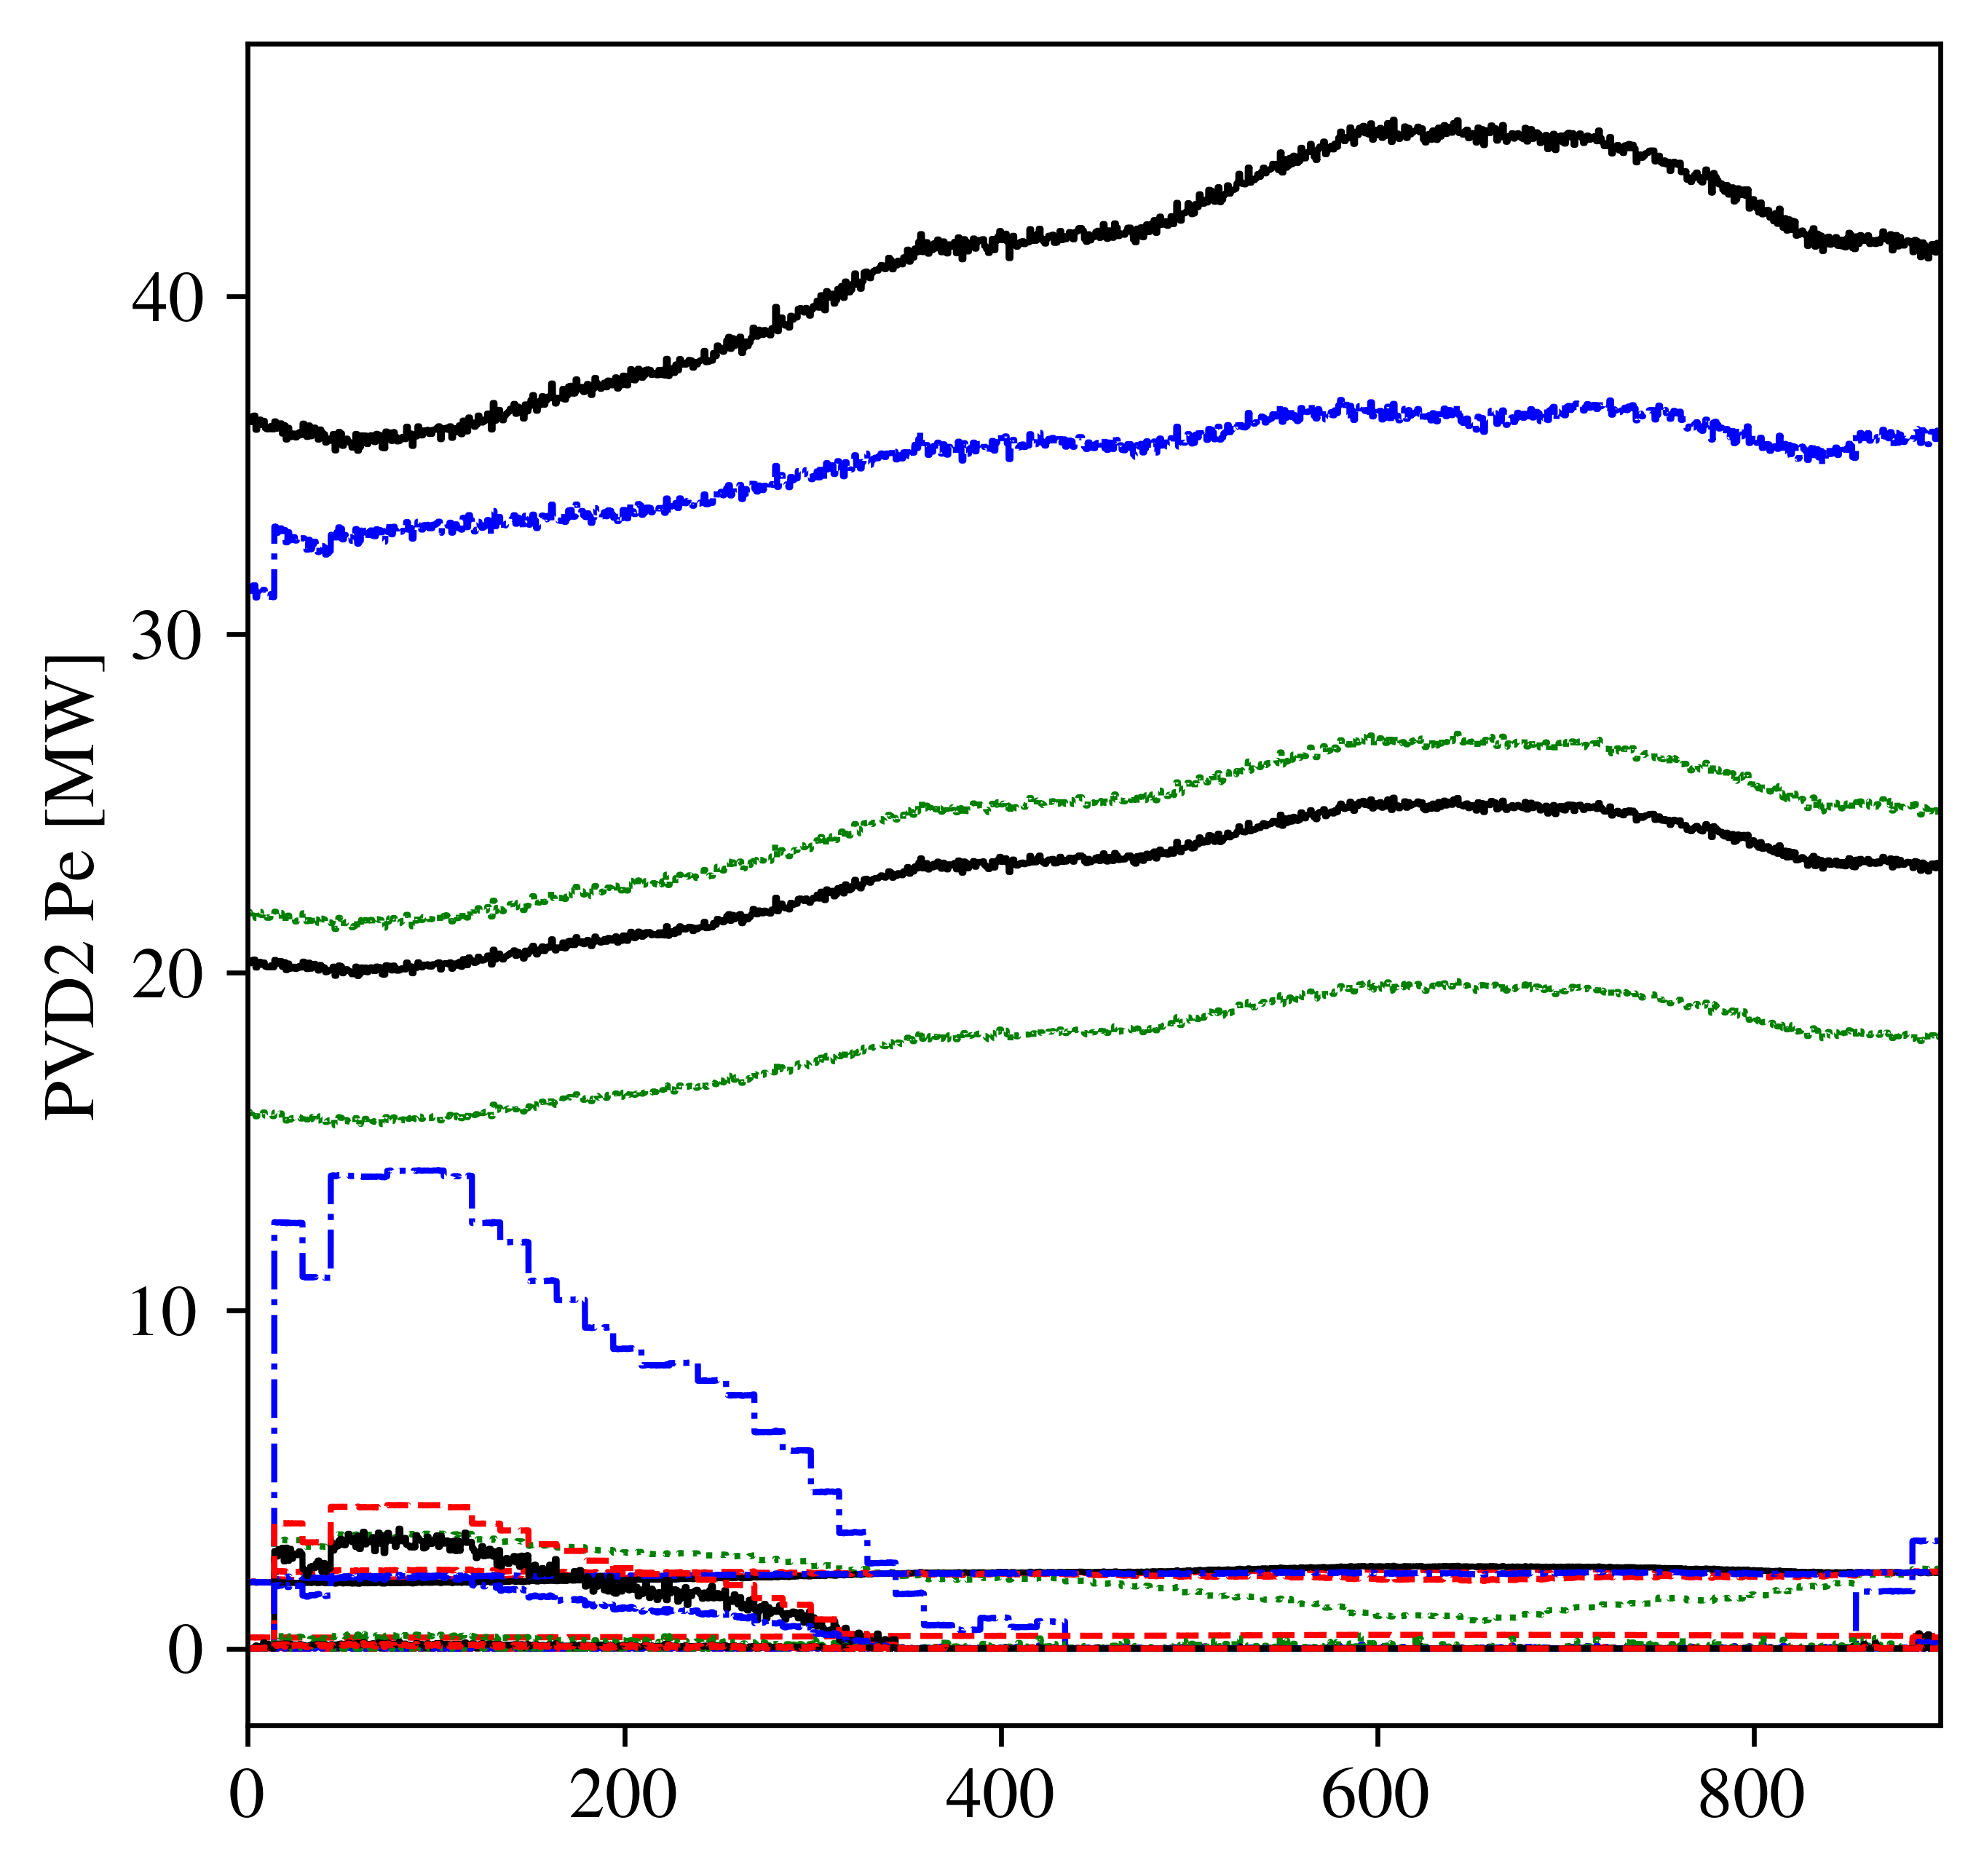

(<Figure size 3000x3000 with 1 Axes>, <Axes: ylabel='PVD2 Pe [MW]'>)

In [12]:
pvd2_pe = sa.config.mva * \
    sa.dae.ts.get_data(sa.PVD2.Ipcmd_y) * sa.dae.ts.get_data(sa.PVD2.v)
sa.TDS.plt.plot_data(sa.dae.ts.t,
                     pvd2_pe,
                     figsize=(5, 5),
                     style=["default", "ieee"],
                     ytimes=sa.config.mva,
                     ylabel='PVD2 Pe [MW]')

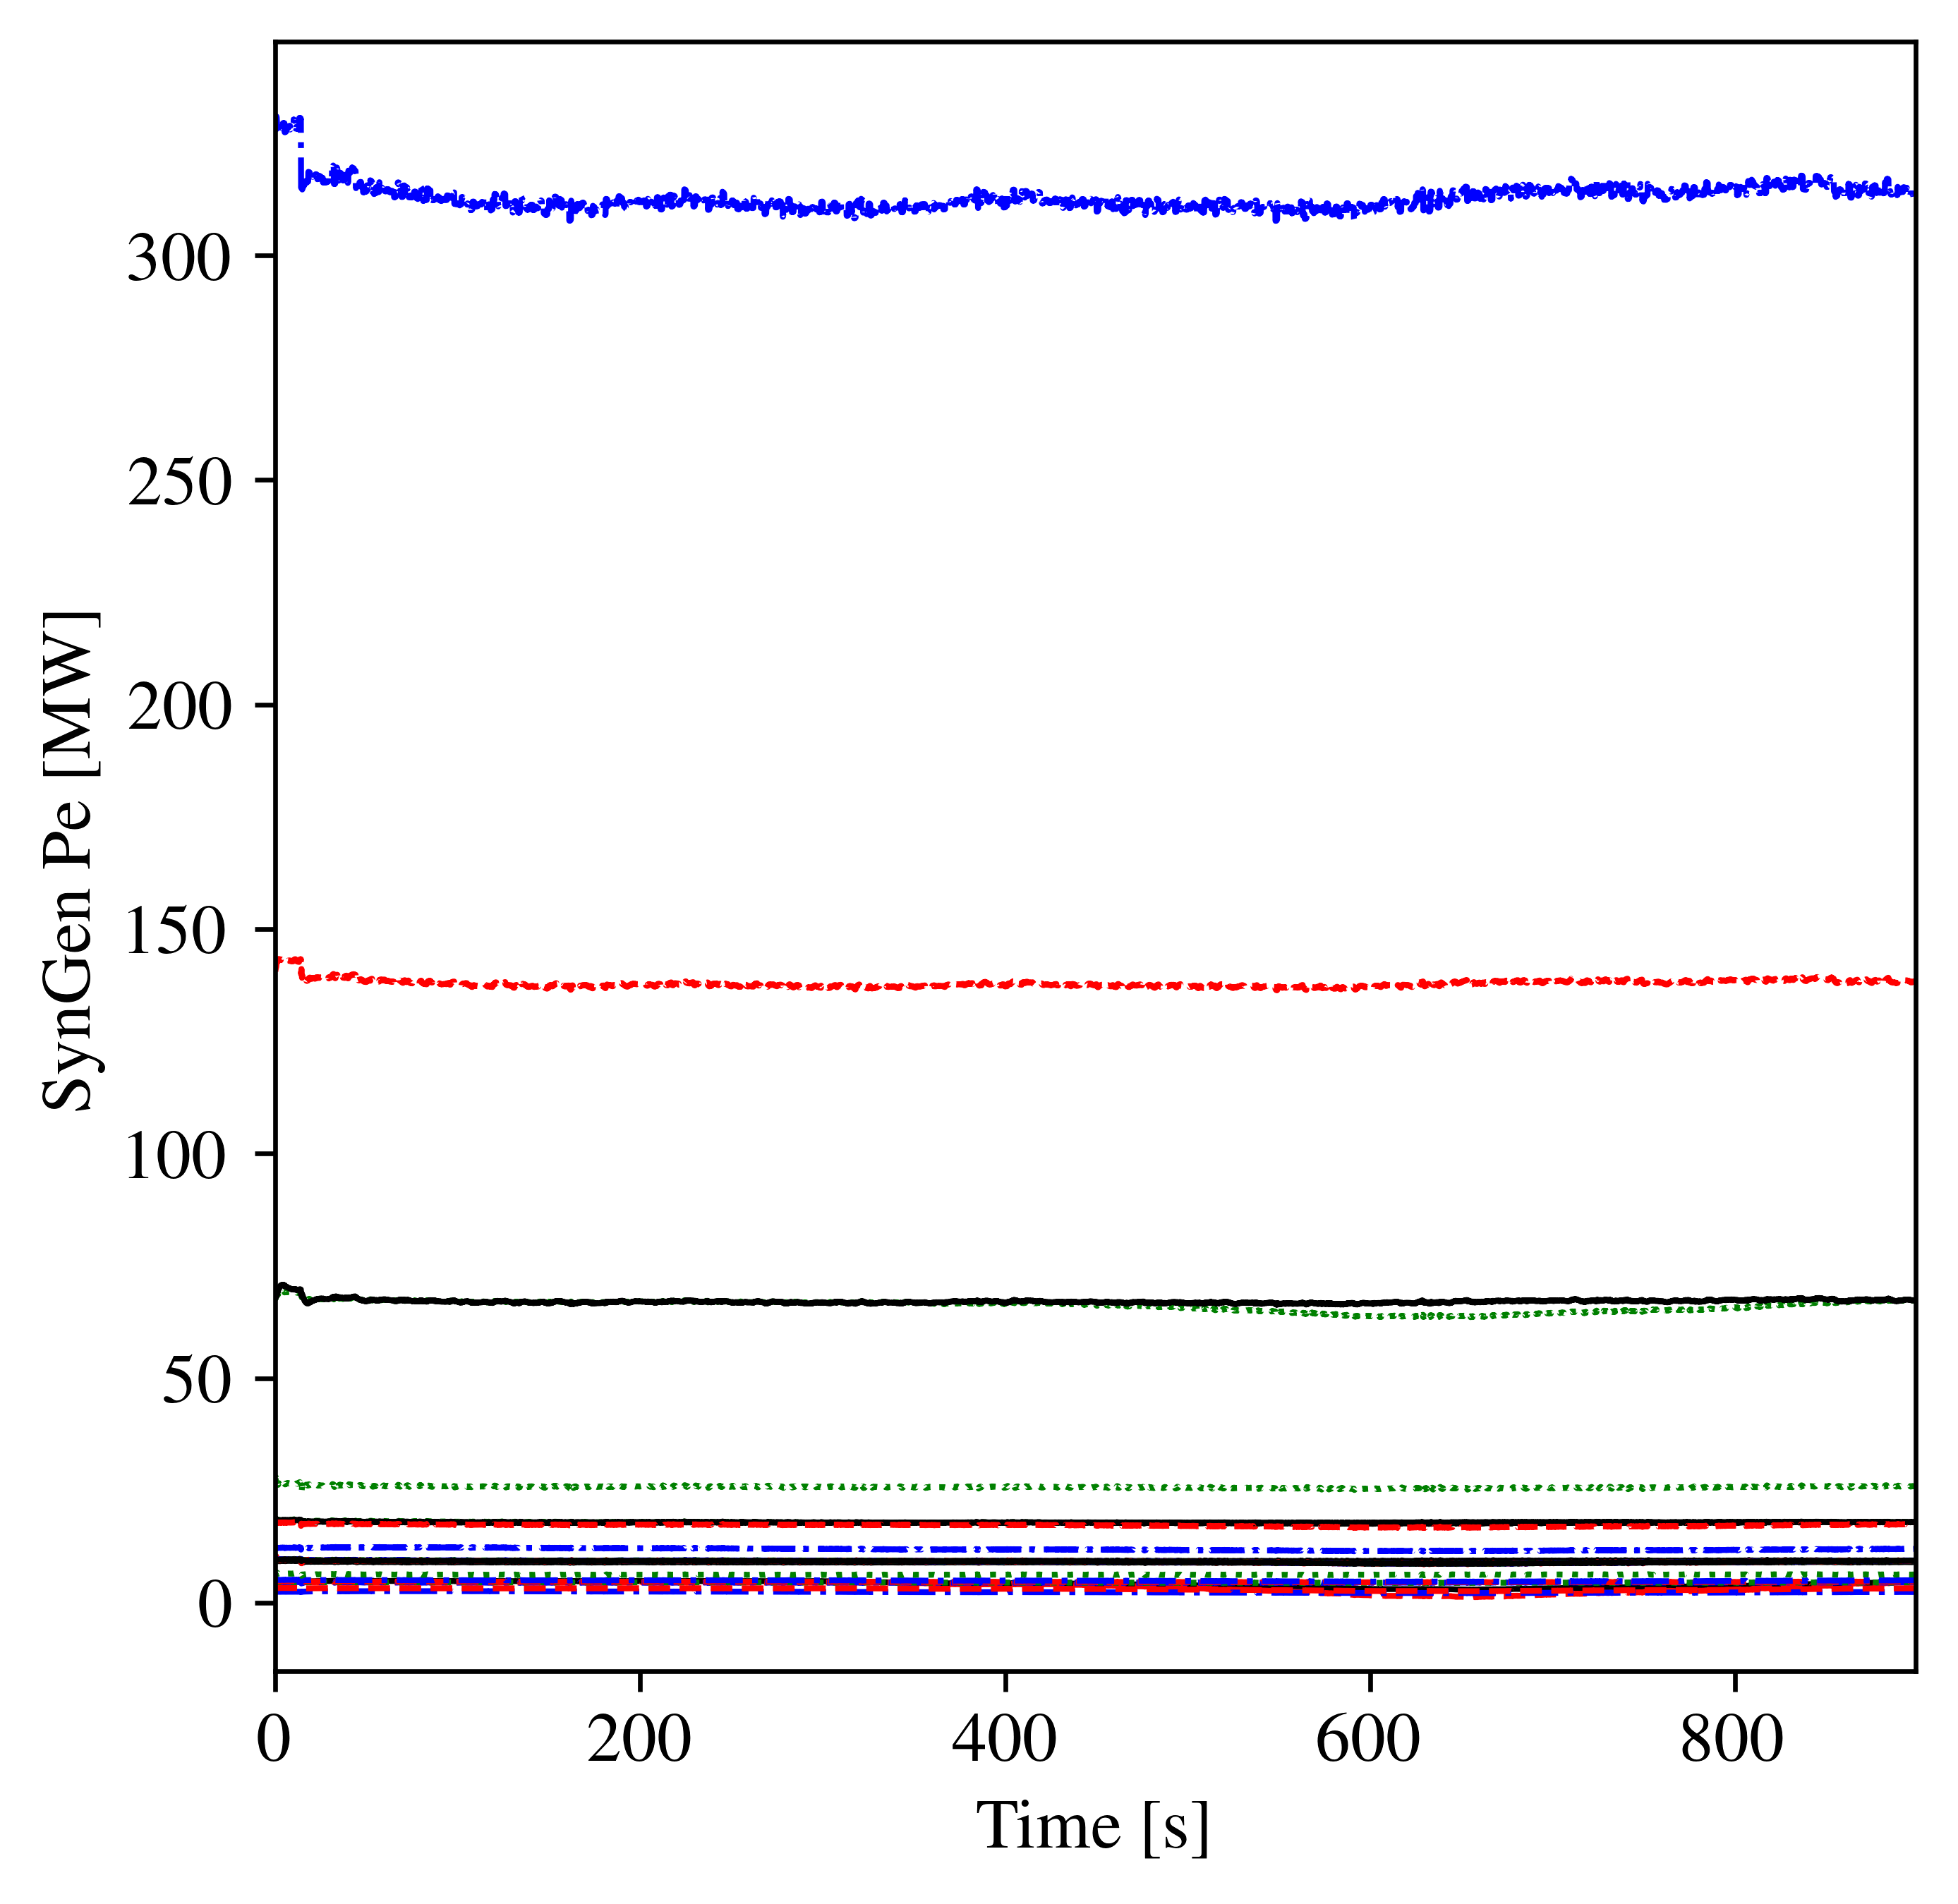

(<Figure size 3000x3000 with 1 Axes>,
 <Axes: xlabel='Time [s]', ylabel='SynGen Pe [MW]'>)

In [13]:
sa.TDS.plt.plot(sa.GENROU.Pe,
                figsize=(5, 5),
                style=["default", "ieee"],
                ytimes=sa.config.mva,
                ylabel='SynGen Pe [MW]')

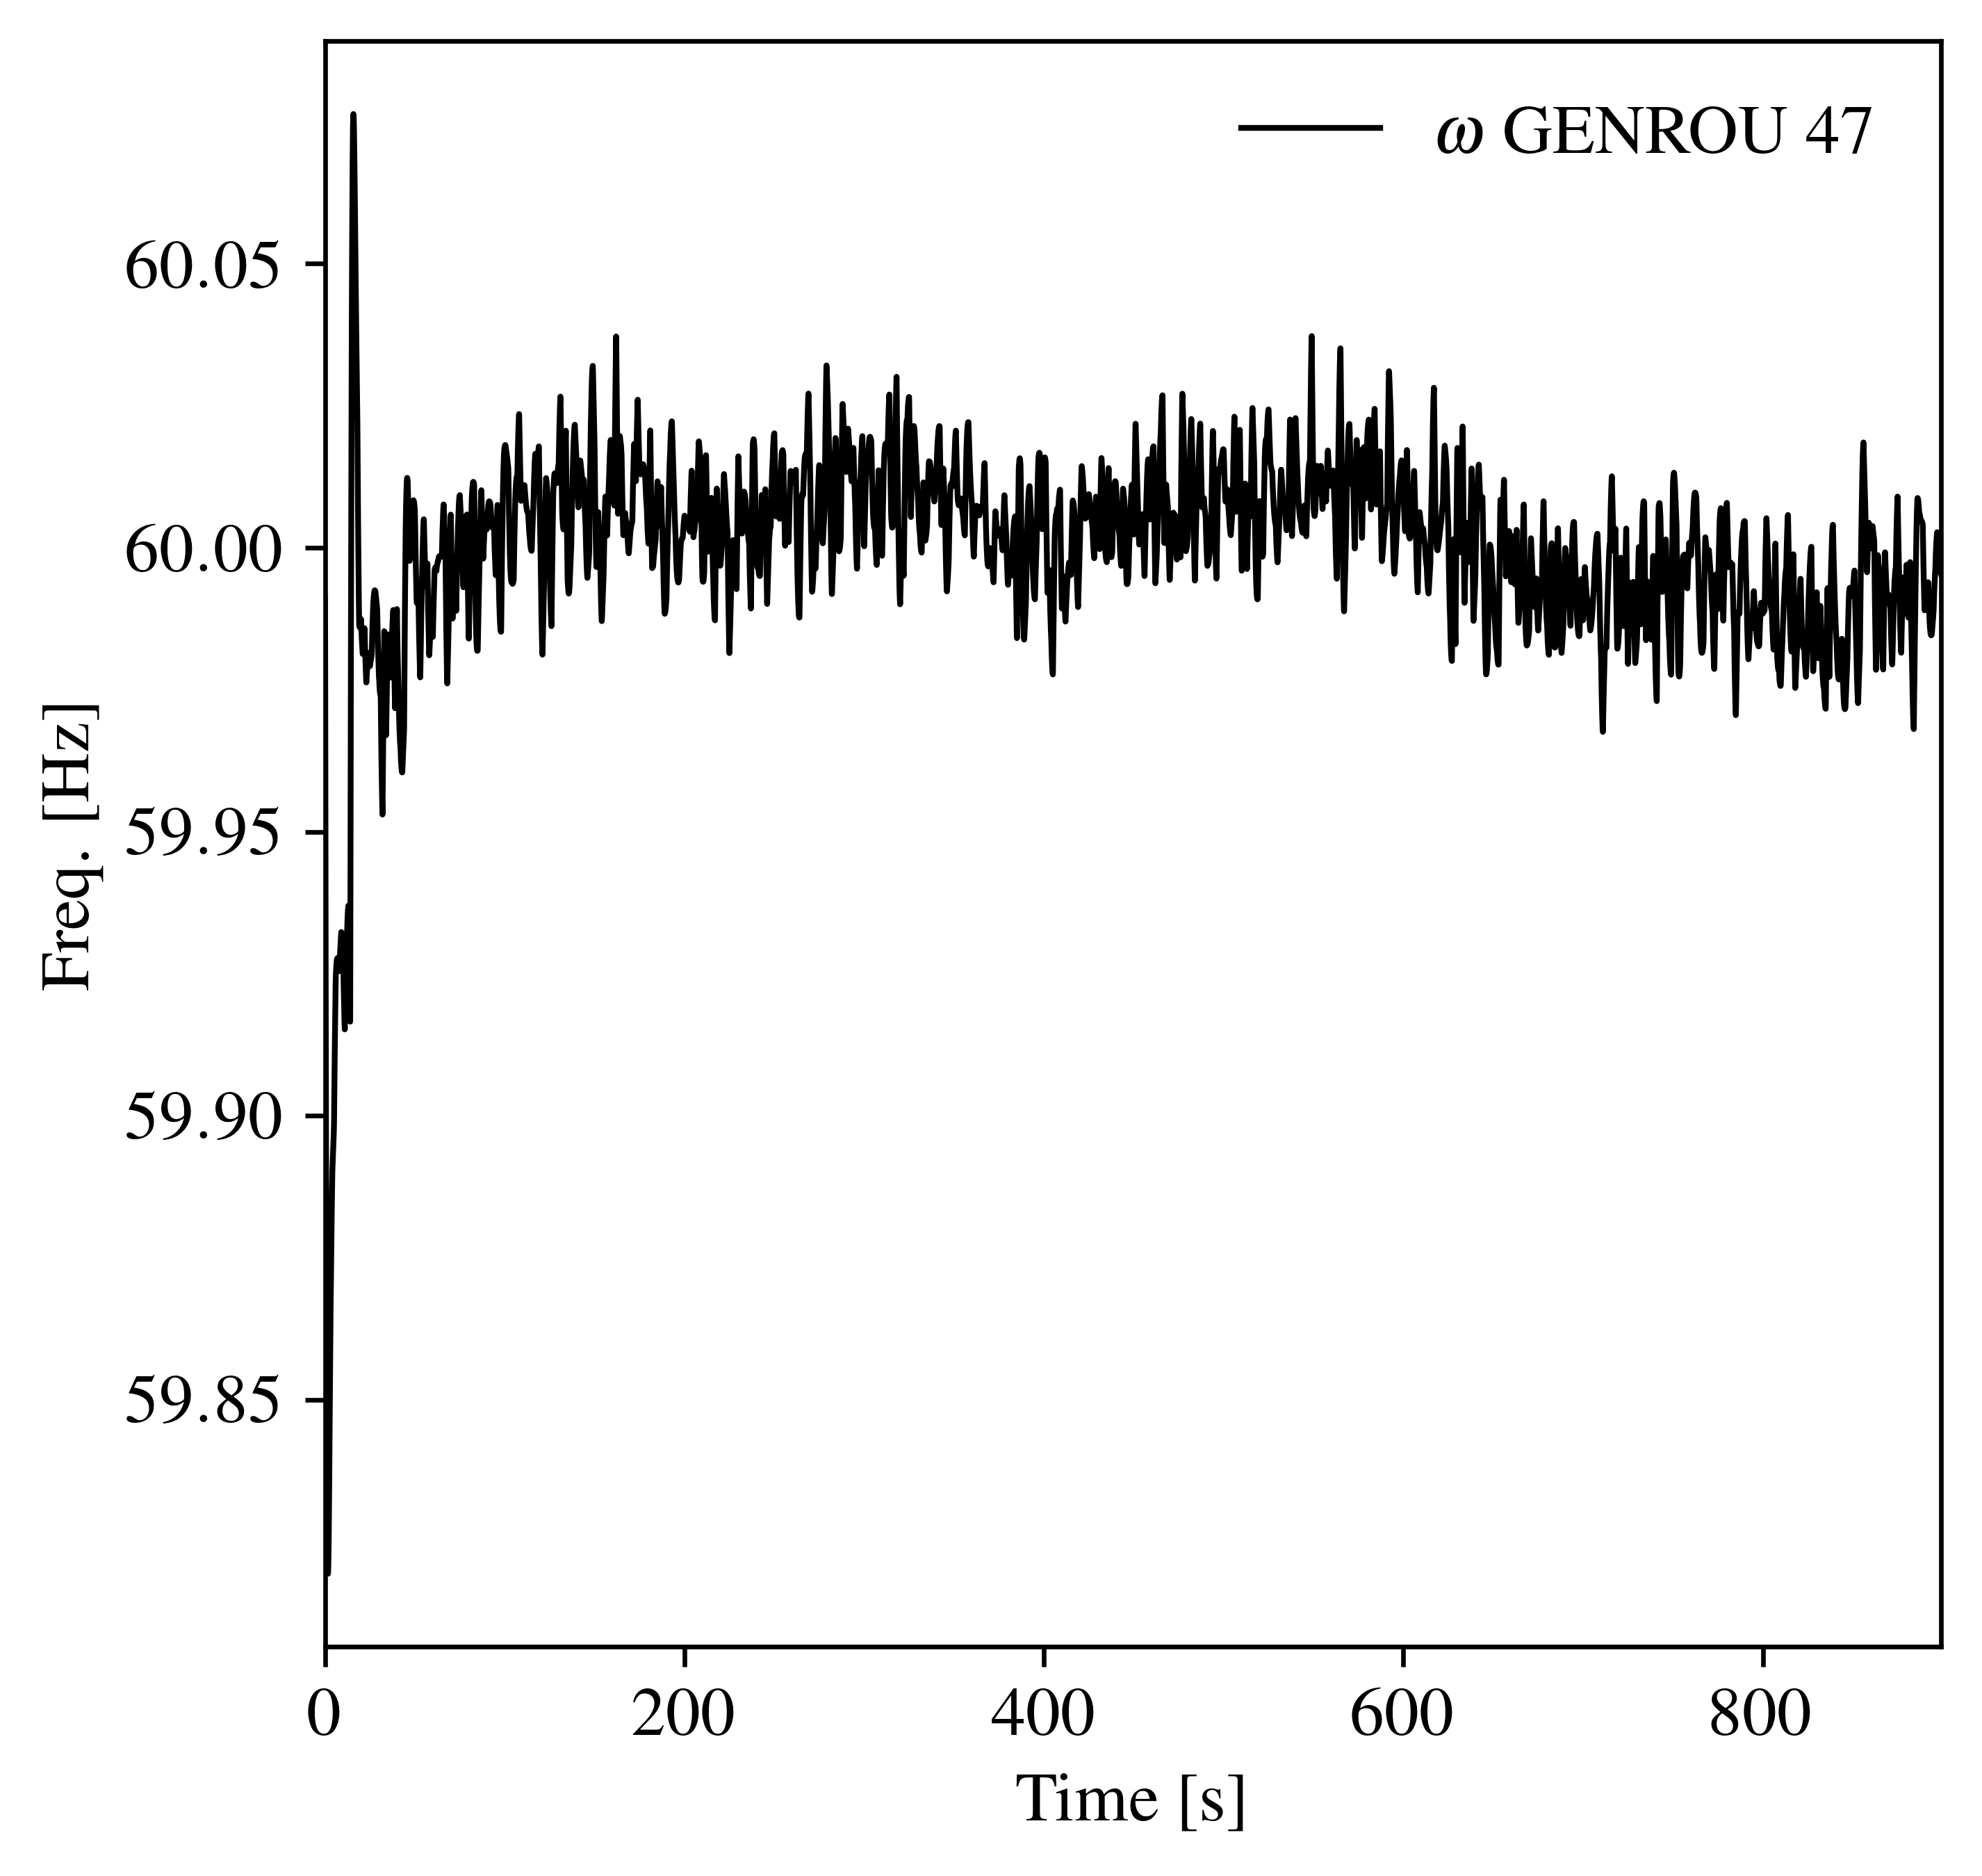

(<Figure size 3000x3000 with 1 Axes>,
 <Axes: xlabel='Time [s]', ylabel='Freq. [Hz]'>)

In [14]:
sa.TDS.plt.plot(sa.GENROU.omega,
                figsize=(5, 5),
                style=["default", "ieee"],
                ytimes=sa.config.freq,
                ylabel='Freq. [Hz]')